In [2]:
import project_path
import os
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict, Any, Union, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

from scipy.stats import spearmanr
from scipy.stats import kstest
from scipy.spatial.distance import jensenshannon

from attwizard.script.utils import read_data_in_parallel
from attwizard.script.utils import load_json_file

# EDA
from attwizard.visualizer.eda import visualize_corr_vs
from attwizard.visualizer.eda import visualize_code_heatmap_codegen
from attwizard.visualizer.eda import plot_histogram_in_parallel

In [3]:
%load_ext autoreload
%autoreload 2

In [8]:
HUMAN_EXPERIMENT = "eye_v10"  # batch 1 and batch 2 and batch 3 and batch 4
MACHINE_EXPERIMENT = "exp_v10"  # CodeGen (3 tries)
COMPARISON_FOLDER = "cmp_v05"
OUT_PAPER_FOLDER = "../data/paper_figures"
COMPARISON_NAMES = ["plain_weights_meanfollowers.csv", "plain_weights_humans.csv"]


# CodeGen

In [9]:
# LOAD COMPARISON DATA
COMPARISON_FOLDER = "cmp_v05"
PATH_COMPARISON_FOLDER = f'../data/comparisons/{COMPARISON_FOLDER}/'
available_comparisons = os.listdir(PATH_COMPARISON_FOLDER)
# intersect with comparison names
available_comparisons = [c for c in available_comparisons if c in COMPARISON_NAMES]
dfs = []
for comparison in tqdm(available_comparisons):
    df = pd.read_csv(os.path.join(PATH_COMPARISON_FOLDER, comparison))
    dfs.append(df)
DF_CODEGEN = pd.concat(dfs)
DF_CODEGEN["comparison_name"].unique()

100%|██████████| 2/2 [00:00<00:00, 113.95it/s]


array(['plain_weights_humans', 'plain_weights_meanfollowers'],
      dtype=object)

In [15]:
KEEP_LOW_PVALUE = True

if not KEEP_LOW_PVALUE:
    DF_CODEGEN = DF_CODEGEN[DF_CODEGEN["pvalue"] < 0.05]

# add the column programming_language dervied from the column source_code
DF_CODEGEN["programming_language"] = DF_CODEGEN["source_code"].apply(
    lambda x: x.split(".")[1])
# define the vector datasets
df_human_vs_model_codegen_same_question_res = DF_CODEGEN[
    (DF_CODEGEN["comparison_name"].isin(["plain_weights_meanfollowers"]))]
df_human_vs_humans_eye_tracking_codegen = DF_CODEGEN[
    (DF_CODEGEN["comparison_name"].isin(["plain_weights_humans"]))]

vector_comparisons_codegen = [
    {
        "short": "human_vs_model_codegen_same_question",
        "long": "Human vs Model (Codegen)",
        'data': df_human_vs_model_codegen_same_question_res,
        'color': 'lightblue'
    },
    {
        "short": "human_vs_human_same_question",
        "long": "Human vs Human ",
        "data": df_human_vs_humans_eye_tracking_codegen,
        'color': 'lime'
    },
    {
        "short": "human_vs_python_same_question",
        "long": "Human vs CodeGen (Python) ",
        "data": df_human_vs_model_codegen_same_question_res[
            (df_human_vs_model_codegen_same_question_res["programming_language"] == "py")],
        'color': 'darkorange'
    },
    {
        "short": "human_vs_csharp_same_question",
        "long": "Human vs CodeGen (C#) ",
        "data": df_human_vs_model_codegen_same_question_res[
            (df_human_vs_model_codegen_same_question_res["programming_language"] == "cs")],
        'color': 'dodgerblue'
    },
    {
        "short": "human_vs_cpp_same_question",
        "long": "Human vs CodeGen (C++) ",
        "data": df_human_vs_model_codegen_same_question_res[
            (df_human_vs_model_codegen_same_question_res["programming_language"] == "cpp")],
        'color': 'darkgreen'
    }
]

print(f'Keep low pvalue: {KEEP_LOW_PVALUE}')

Keep low pvalue: True


In [12]:
# GPT-J
# LOAD COMPARISON DATA
COMPARISON_FOLDER = "cmp_v05_gptj"
PATH_COMPARISON_FOLDER = f'../data/comparisons/{COMPARISON_FOLDER}/'
available_comparisons = os.listdir(PATH_COMPARISON_FOLDER)
# intersect with comparison names
available_comparisons = [c for c in available_comparisons if c in COMPARISON_NAMES]
dfs = []
for comparison in tqdm(available_comparisons):
    df = pd.read_csv(os.path.join(PATH_COMPARISON_FOLDER, comparison))
    dfs.append(df)
DF_GPTJ = pd.concat(dfs)
DF_GPTJ["comparison_name"].unique()


100%|██████████| 2/2 [00:00<00:00, 116.27it/s]


array(['plain_weights_humans', 'plain_weights_meanfollowers'],
      dtype=object)

In [16]:
KEEP_LOW_PVALUE = True

if not KEEP_LOW_PVALUE:
    DF_GPTJ = DF_GPTJ[DF_GPTJ["pvalue"] < 0.05]

# add the column programming_language dervied from the column source_code
DF_GPTJ["programming_language"] = DF_GPTJ["source_code"].apply(
    lambda x: x.split(".")[1])
# define the vector datasets
df_human_vs_model_gptj_same_question_res = DF_GPTJ[
    (DF_GPTJ["comparison_name"].isin(["plain_weights_meanfollowers"]))]
df_human_vs_humans_eye_tracking_gptj = DF_GPTJ[
    (DF_GPTJ["comparison_name"].isin(["plain_weights_humans"]))]

vector_comparisons_gptj = [
    {
        "short": "human_vs_model_codegen_same_question",
        "long": "Human vs Model (Gpt-j) ",
        'data': df_human_vs_model_gptj_same_question_res,
        'color': 'lightblue'
    },
    {
        "short": "human_vs_human_same_question",
        "long": "Human vs Human ",
        "data": df_human_vs_humans_eye_tracking_gptj,
        'color': 'lime'
    },
    {
        "short": "human_vs_python_same_question",
        "long": "Human vs Gpt-j (Python) ",
        "data": df_human_vs_model_gptj_same_question_res[
            (df_human_vs_model_gptj_same_question_res["programming_language"] == "py")],
        'color': 'darkorange'
    },
    {
        "short": "human_vs_csharp_same_question",
        "long": "Human vs Gpt-j (C#) ",
        "data": df_human_vs_model_gptj_same_question_res[
            (df_human_vs_model_gptj_same_question_res["programming_language"] == "cs")],
        'color': 'dodgerblue'
    },
    {
        "short": "human_vs_cpp_same_question",
        "long": "Human vs Gpt-j (C++) ",
        "data": df_human_vs_model_gptj_same_question_res[
            (df_human_vs_model_gptj_same_question_res["programming_language"] == "cpp")],
        'color': 'darkgreen'
    }
]

print(f'Keep low pvalue: {KEEP_LOW_PVALUE}')

Keep low pvalue: True


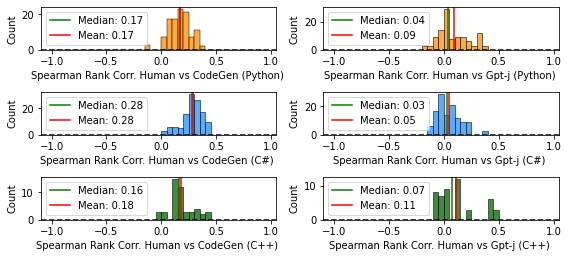

In [29]:
PL_LONG_NAMES = ["Python", "C#", "C++"]
pl_comparisons = [
    c
    for c in vector_comparisons_codegen + vector_comparisons_gptj
    if any([l in c["long"] for l in PL_LONG_NAMES])
]
plot_histogram_in_parallel(
    pl_comparisons,
    col_name="correlation",
    common_prefix="Spearman Rank Corr.",
    bins=np.arange(-1, 1, 0.05),
    n_cols=2,
    filling_direction="vertical",
    width=8,
    vertical_zero_line=True, 
    out_path=os.path.join(OUT_PAPER_FOLDER, "human_vs_model_pl_agreement.pdf"),
)

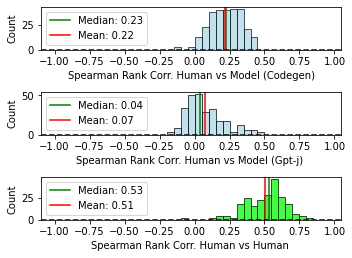

In [31]:
plot_histogram_in_parallel(
    vector_comparisons_codegen[:1] + vector_comparisons_gptj[:2],
    col_name="correlation",
    common_prefix="Spearman Rank Corr.",
    bins=np.arange(-1, 1, 0.05),
    vertical_zero_line=True, 
    out_path=os.path.join(OUT_PAPER_FOLDER, "human_vs_models_vector_agreement.pdf"),
)

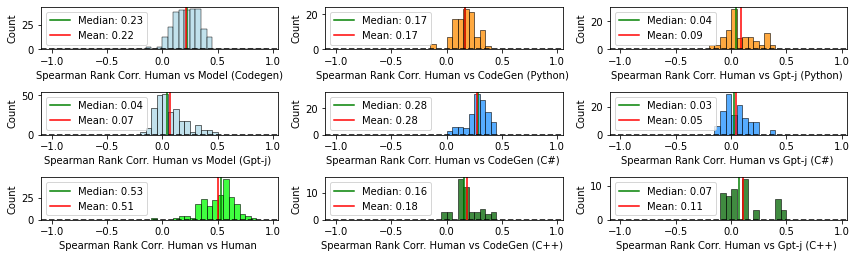

In [38]:
PL_LONG_NAMES = ["Python", "C#", "C++"]
pl_comparisons = [
    c
    for c in vector_comparisons_codegen + vector_comparisons_gptj
    if any([l in c["long"] for l in PL_LONG_NAMES])
]
all_comparisons = vector_comparisons_codegen[:1] + vector_comparisons_gptj[:2] + pl_comparisons
plot_histogram_in_parallel(
    all_comparisons,
    col_name="correlation",
    common_prefix="Spearman Rank Corr.",
    bins=np.arange(-1, 1, 0.05),
    n_cols=3,
    filling_direction="vertical",
    width=12,
    vertical_zero_line=True, 
    out_path=os.path.join(OUT_PAPER_FOLDER, "human_vs_model_agreement_all_and_pl.pdf"),
)

# Mann Whitney U test

In [35]:
# Example of the Mann-Whitney U Test 
from scipy.stats import mannwhitneyu 
PAIRS = [
    ['py', 'cpp'],
    ['py', 'cs'],
    ['cpp', 'cs'],
]
records = []
for lang_a, lang_b in PAIRS: 
    print(f'Comparing {lang_a} vs {lang_b}')
    for df, name in [
            (df_human_vs_model_gptj_same_question_res, 'Gpt-j'),
            (df_human_vs_model_codegen_same_question_res, 'Codegen'),]:
        print(f'\tDataset Model:  {name}')
        data_a = df[df["programming_language"] == lang_a]["correlation"] 
        data_b = df[df["programming_language"] == lang_b]["correlation"] 
        stat, p = mannwhitneyu(data_a, data_b) 
        # scientific notation with 2 decimals
        print(f'\tstat={stat:.3f}, p={p:.2e}') 
        if p > 0.05: 
            print('\tProbably the same distribution') 
        else: 
            print('\tProbably different distributions')
        records.append({
            'Neural Model': name,
            'Lang. A': lang_a,
            'Lang. B': lang_b,
            'Statistic': stat,
            'p-value': p,
            'Result': 'Probably same distrib.' if p > 0.05 else 'Probably diff. distrib.'
        })

df_latex_table = pd.DataFrame.from_records(records)
# format the p-value column with 2 decimals and scientific notation
df_latex_table["p-value"] = df_latex_table["p-value"].apply(lambda x: f'{x:.2e}')
# print leatx code
print(df_latex_table.to_latex(index=False))

Comparing py vs cpp
	Dataset Model:  Gpt-j
	stat=2613.000, p=9.37e-01
	Probably the same distribution
	Dataset Model:  Codegen
	stat=2499.000, p=7.22e-01
	Probably the same distribution
Comparing py vs cs
	Dataset Model:  Gpt-j
	stat=7637.000, p=2.00e-02
	Probably different distributions
	Dataset Model:  Codegen
	stat=2626.000, p=9.29e-15
	Probably different distributions
Comparing cpp vs cs
	Dataset Model:  Gpt-j
	stat=3404.000, p=6.61e-02
	Probably the same distribution
	Dataset Model:  Codegen
	stat=1486.000, p=9.95e-07
	Probably different distributions
\begin{tabular}{lllrll}
\toprule
Neural Model & Lang. A & Lang. B &  Statistic &  p-value &                  Result \\
\midrule
       Gpt-j &      py &     cpp &     2613.0 & 9.37e-01 &  Probably same distrib. \\
     Codegen &      py &     cpp &     2499.0 & 7.22e-01 &  Probably same distrib. \\
       Gpt-j &      py &      cs &     7637.0 & 2.00e-02 & Probably diff. distrib. \\
     Codegen &      py &      cs &     2626.0 & 9.2

/tmp/ipykernel_2651969/3116067965.py:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_latex_table.to_latex(index=False))


# Sampling

In [7]:
# GOAL: we want to see how much the agreemnent changes in groups where we only 
# comparisons on tasks with the same programming language (PL) vs groups of 
# comparisons on randomly picked tasks (even of different PLs).
N_TASKS_PER_GROUP = 100
N_REPETITIONS = 30
df = df_human_vs_model_codegen_same_question_res

len(df)

276

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 275
Data columns (total 60 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   comparison_name                                     276 non-null    object 
 1   comparison_function                                 276 non-null    object 
 2   source_code                                         276 non-null    object 
 3   user_name                                           276 non-null    object 
 4   task_number                                         276 non-null    float64
 5   input_human_filestem                                276 non-null    object 
 6   input_machine_filestem                              276 non-null    object 
 7   comparison_type                                     276 non-null    object 
 8   top_3                                               0 non-null      float64
 9  

100%|██████████| 10000/10000 [00:18<00:00, 527.12it/s]


(-1.0, 1.0)

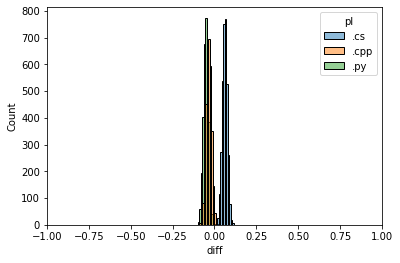

In [29]:
LANGUAGES = ['.py', '.cpp', '.cs']
records_diffs = []

# set the seed
np.random.seed(42)
N_REPETITIONS = 10000

for i in tqdm(range(N_REPETITIONS)):

    # CREATE THE SAME-PL GROUP
    # pick a random langauge
    random_lang = np.random.choice(LANGUAGES)
    #print(f"Random language: {random_lang}")
    df_pl_group = df[df["source_code"].str.endswith(random_lang)]
    #print(f"Number of tasks in the PL group: {len(df_pl_group)}")
    # pick a random subset of tasks
    df_pl_group = df_pl_group.sample(n=N_TASKS_PER_GROUP, replace=True)

    # CREATE THE RANDOM-PL GROUP
    df_random_group = df.sample(n=N_TASKS_PER_GROUP, replace=True)

    # COMPUTE THE DIFFERENCE BETWEEN THE AVERAGE OF TE TWO GROUPS
    avg_pl_group = df_pl_group["correlation"].mean()
    avg_random_group = df_random_group["correlation"].mean()
    diff = avg_pl_group - avg_random_group

    # STORE THE DIFFERENCE
    records_diffs.append({
        "diff": diff,
        "avg_pl_group": avg_pl_group,
        "avg_random_group": avg_random_group,
        "pl": random_lang,
        "type": 'pl'
    })

    # CREATE ANOTHER RANDOM-PL GROUP
    df_random_group_bis = df.sample(n=N_TASKS_PER_GROUP, replace=True)
    avg_random_group_bis = df_random_group_bis["correlation"].mean()
    records_diffs.append({
        "diff": diff,
        "avg_random_group": avg_random_group,
        "avg_random_group_bis": avg_random_group_bis,
        "type": 'random'
    })

df_results = pd.DataFrame.from_records(records_diffs)
df_results_diff_pl = df_results[df_results["type"] == 'pl']
df_results_diff_random = df_results[df_results["type"] == 'random']

# PLOT THE DISTRIBUTION OF THE DIFFERENCES
sns.histplot(
    data=df_results_diff_pl,
    x="diff",
    hue="pl",
)
plt.xlim(-1, 1)

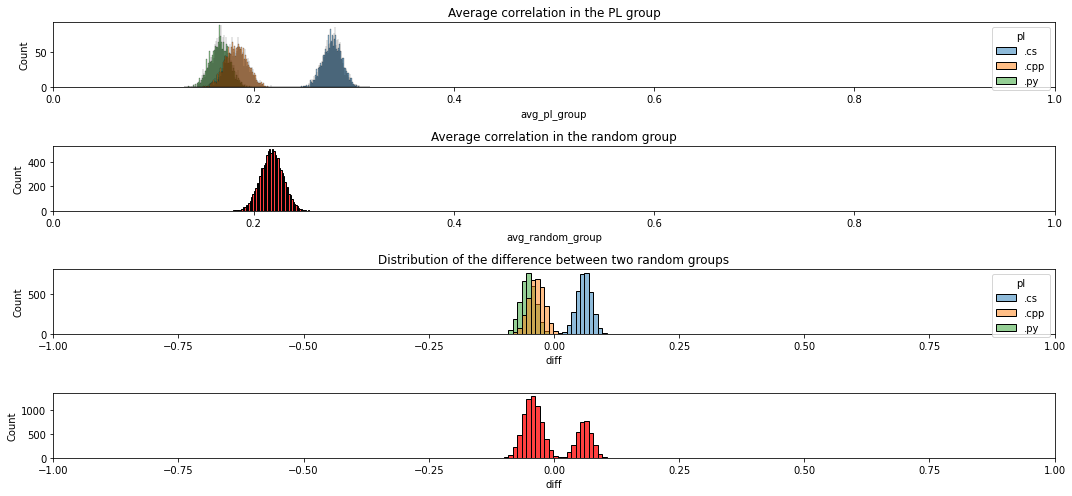

In [38]:
# PLOT THE DISTRIBUTION OF THE DIFFERENCES
fig, axes = plt.subplots(4, 1, figsize=(15, 7))
ax_pl = axes[0]
ax_random = axes[1]
ax_diff = axes[2]
ax_diff_random_groups = axes[3]

sns.histplot(
    data=df_results_diff_pl,
    x="avg_pl_group",
    hue="pl",
    binwidth=0.0005,
    ax=ax_pl
)
ax_pl.set_xlim(0, 1)
ax_pl.set_title("Average correlation in the PL group")

sns.histplot(
    data=df_results_diff_pl,
    x="avg_random_group",
    ax=ax_random,
    color="red"
)
ax_random.set_xlim(0, 1)
ax_random.set_title("Average correlation in the random group")

sns.histplot(
    data=df_results_diff_pl,
    x="diff",
    hue="pl",
    ax=ax_diff,
)
ax_diff.set_xlim(-1, 1)
ax_diff.set_title("Distribution of the difference between a PL group and a random group")

sns.histplot(
    data=df_results_diff_random,
    x="diff",
    ax=ax_diff_random_groups,
    color="red"
)
ax_diff_random_groups.set_xlim(-1, 1)
ax_diff.set_title("Distribution of the difference between two random groups")

plt.tight_layout()

In [35]:
# Check if the mean of each PL group is significantly different from the mean of the random group

from scipy.stats import ttest_ind

def test_mean(data_1, data_2):
    """Run the t-test to see if the two means are significantly different."""
    stat, p = ttest_ind(data_1, data_2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

PAIRS = [
    ['.py', '.cpp'],
    ['.py', '.cs'],
    ['.cpp', '.cs'],
]

for pair in PAIRS:
    pl_1, pl_2 = pair
    print("=" * 80)
    print(f"Testing avg correaltion of {pl_1} vs {pl_2} groups")
    data_1 = df_results_diff_pl[df_results_diff_pl["pl"] == pl_1]["avg_pl_group"]
    data_2 = df_results_diff_pl[df_results_diff_pl["pl"] == pl_2]["avg_pl_group"]
    test_mean(data_1, data_2)


Testing avg correaltion of .py vs .cpp groups
stat=-62.630, p=0.000
Probably different distributions
Testing avg correaltion of .py vs .cs groups
stat=-464.599, p=0.000
Probably different distributions
Testing avg correaltion of .cpp vs .cs groups
stat=-372.287, p=0.000
Probably different distributions
